In [1]:
import ee
import geemap
import os
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from tqdm import tqdm

In [2]:
# Initialize the Earth Engine API
try:
    ee.Authenticate()
    ee.Initialize()
    print("Earth Engine API initialized successfully.")
except Exception as e:
    print(f"Error initializing Earth Engine API: {e}")
    print("Make sure you have authenticated with Earth Engine using ee.Authenticate()")


Earth Engine API initialized successfully.


In [3]:
def get_goa_boundary():
    """Get the administrative boundary for Goa, India."""
    try:
        # Get the Goa district boundary from Earth Engine's administrative boundaries
        goa = ee.FeatureCollection("FAO/GAUL/2015/level1").filter(ee.Filter.eq('ADM1_NAME', 'Goa'))
        return goa.geometry()
    except Exception as e:
        print(f"Could not load Goa boundary from Earth Engine: {e}")
        
        # Try to load from shapefile as fallback
        try:
            boundary_path = os.path.join('data', 'pa_boundary.shp')
            if os.path.exists(boundary_path):
                boundary_gdf = gpd.read_file(boundary_path)
                # Convert to GeoJSON
                boundary_geojson = boundary_gdf.geometry.__geo_interface__
                # Create an EE geometry
                return ee.Geometry.Polygon(boundary_geojson['features'][0]['geometry']['coordinates'])
        except Exception as e:
            print(f"Could not load boundary from shapefile: {e}")
        
        # Manual definition as last resort
        goa_coords = [
            [73.6765, 15.7560],
            [74.3161, 15.7560],
            [74.3161, 14.8922],
            [73.6765, 14.8922],
            [73.6765, 15.7560]
        ]
        return ee.Geometry.Polygon(goa_coords)

In [4]:
def maskL8sr(image):
    """
    Mask clouds and scale pixel values for Landsat 8 SR imagery.
    """
    # Get QA band
    qa = image.select('QA_PIXEL')
    
    # Bits 3 and 5 are cloud shadow and cloud, respectively
    cloud_shadow_bit_mask = 1 << 3
    clouds_bit_mask = 1 << 5
    
    # Both flags should be set to zero, indicating clear conditions
    mask = qa.bitwiseAnd(cloud_shadow_bit_mask).eq(0).And(
           qa.bitwiseAnd(clouds_bit_mask).eq(0))
    
    # Scale the optical bands
    optical_bands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    
    # Scale the thermal bands
    thermal_bands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    
    # Return the masked and scaled image
    return image.select(['QA_.*']).addBands(optical_bands).addBands(thermal_bands).updateMask(mask)

In [5]:
def addIndices(image):
    """
    Calculate various spectral indices and add them as bands to the image.
    Match JavaScript version exactly.
    """
    # NDVI (Normalized Difference Vegetation Index)
    ndvi = image.normalizedDifference(['SR_B5', 'SR_B4']).rename('ndvi')
    
    # MIRBI (Mid-Infrared Burn Index)
    mirbi = image.expression(
        '10 * swir1 - 9.8 * swir2 + 2',
        {
            'swir1': image.select('SR_B6'),
            'swir2': image.select('SR_B7')
        }
    ).rename('mirbi')
    
    # NDFI (Normalized Difference Fire Index) - Corrected to match JS
    ndfi = image.normalizedDifference(['ST_B10', 'SR_B6']).rename('ndfi')
    
    # EVI (Enhanced Vegetation Index)
    evi = image.expression(
        '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))',
        {
            'NIR': image.select('SR_B5'),
            'RED': image.select('SR_B4'),
            'BLUE': image.select('SR_B2')
        }
    ).rename('evi')
    
    # BSI (Bare Soil Index)
    bsi = image.expression(
        '((X + Y) - (A + B)) / ((X + Y) + (A + B))',
        {
            'X': image.select('SR_B6'),
            'Y': image.select('SR_B4'),
            'A': image.select('SR_B5'),
            'B': image.select('SR_B2')
        }
    ).rename('bsi')
    
    # NDMI (Normalized Difference Moisture Index)
    ndmi = image.normalizedDifference(['SR_B5', 'SR_B6']).rename('ndmi')
    
    # NBR (Normalized Burn Ratio)
    nbr = image.normalizedDifference(['SR_B5', 'SR_B7']).rename('nbr')
    
    # NBR2 (Normalized Burn Ratio 2)
    nbr2 = image.normalizedDifference(['SR_B6', 'SR_B7']).rename('nbr2')
    
    # MSAVI (Modified Soil Adjusted Vegetation Index)
    msavi = image.expression(
        '(2 * NIR + 1 - sqrt((2 * NIR + 1) ** 2 - 8 * (NIR - RED))) / 2',
        {
            'NIR': image.select('SR_B5'),
            'RED': image.select('SR_B4')
        }
    ).rename('msavi')
    
    return image.addBands([ndvi, evi, msavi, mirbi, ndmi, ndfi, nbr, nbr2, bsi])

In [6]:
# Function to calculate SMI (Soil Moisture Index)
def calculateSMI(image):
    """
    Calculate Soil Moisture Index (SMI) from Landsat data.
    """
    Ts = image.select('ST_B10')
    ndvi = image.select('ndvi')
    
    # Apply the SMI calculation
    smi = image.expression(
        '(Ts_max - Ts) / (Ts_max - Ts_min)',
        {
            'Ts': Ts,
            'Ts_max': Ts.reduceRegion(
                reducer=ee.Reducer.max(),
                geometry=image.geometry(),
                scale=30,
                maxPixels=1e9
            ).get('ST_B10'),
            'Ts_min': Ts.reduceRegion(
                reducer=ee.Reducer.min(),
                geometry=image.geometry(),
                scale=30,
                maxPixels=1e9
            ).get('ST_B10')
        }
    ).rename('smi')
    
    return image.addBands(smi)

In [7]:
def process_landsat_trends(goa, start_date='2013-03-20', end_date='2023-02-28'):
    """
    Process Landsat 8 data to calculate vegetation and burn index trends.
    Fixed to handle date calculations properly.
    
    Args:
        goa: Earth Engine geometry for Goa
        start_date: Start date for analysis
        end_date: End date for analysis
        
    Returns:
        Tuple of (trend image, Landsat collection)
    """
    print(f"Processing Landsat 8 data for {start_date} to {end_date}...")
    
    # Convert dates to ee.Date objects
    ee_start_date = ee.Date(start_date)
    ee_end_date = ee.Date(end_date)
    
    # Load Landsat 8 collection
    ls8 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
        .filterDate(start_date, end_date) \
        .filterBounds(goa)
    
    # Apply cloud masking and add indices
    ls8_masked = ls8.map(maskL8sr).map(addIndices)
    
    # Filter out images with too many clouds
    ls8_filtered = ls8_masked.filter(ee.Filter.lt('CLOUD_COVER', 80))
    
    # Add a time band (fixed version)
    def add_time_band(image):
        # Get image timestamp
        date = ee.Date(image.get('system:time_start'))
        
        # Get the year (server-side)
        year = date.get('year')
        
        # Calculate days since the start of the analysis (safer approach)
        days_since_start = date.difference(ee_start_date, 'day')
        
        # Normalize to years (for better coefficient interpretation)
        years_since_start = days_since_start.divide(365)
        
        # Create an image with this value
        time_band = ee.Image.constant(years_since_start).float().rename('t')
        
        # Add date info as properties (for debugging)
        return image.addBands(time_band).set({
            'year': year,
            'days_since_start': days_since_start,
            'years_since_start': years_since_start
        })
    
    # Add time bands
    ls8_time = ls8_filtered.map(add_time_band)
    
    # Define the bands to calculate trends for
    trend_bands = ['ndvi', 'evi', 'msavi', 'mirbi', 'ndmi', 'ndfi', 'nbr', 'nbr2', 'bsi']
    
    # Calculate trends for each band
    trends = {}
    
    for band in trend_bands:
        print(f"Calculating trend for {band}...")
        
        # Define the dependent and independent variables
        trend_x = 't'
        trend_y = band
        
        # Calculate trend (slope and intercept)
        trend = ls8_time.select([trend_x, trend_y]).reduce(
            ee.Reducer.linearFit()
        )
        
        # Rename the bands
        trend = trend.select(['scale'], [f'{band}_Slope'])
        
        # Store in dictionary
        trends[band] = trend
    
    # Merge all trend images
    all_trends = ee.Image.cat(list(trends.values()))
    
    print("Landsat trend calculation complete.")
    
    return all_trends, ls8_filtered

In [8]:
# Function to process CHIRPS precipitation data
def process_chirps_trends(goa, start_date='2013-01-01', end_date='2022-12-31'):
    """
    Process CHIRPS precipitation data and calculate rainfall trends.
    """
    print("Processing CHIRPS precipitation data and calculating trends...")
    
    # Load CHIRPS data
    chirps = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY') \
        .filterDate(start_date, end_date) \
        .filterBounds(goa)
    
    # Function to compute the yearly sum
    def createYearlySum(year):
        # Filter for the specific year
        year_filter = chirps.filter(ee.Filter.calendarRange(year, year, 'year'))
        
        # Create the yearly sum
        yearly_sum = year_filter.sum().clip(goa)
        
        # Add the year as a property
        return yearly_sum.set('year', year) \
                         .set('system:time_start', ee.Date.fromYMD(year, 1, 1).millis()) \
                         .rename('precipitation')
    
    # Create a list of yearly sums
    years = ee.List.sequence(int(start_date[:4]), int(end_date[:4]))
    yearly_sums = years.map(createYearlySum)
    
    # Convert to ImageCollection
    yearly_sums_collection = ee.ImageCollection.fromImages(yearly_sums)
    
    # Calculate trend
    def addTime(image):
        return image.addBands(image.metadata('system:time_start').divide(1000 * 60 * 60 * 24 * 365).rename('t'))
    
    collection_with_time = yearly_sums_collection.map(addTime)
    
    # Calculate linear regression
    trend = collection_with_time.select(['t', 'precipitation']).reduce(ee.Reducer.linearFit())
    
    # Rename bands
    rain_trend = trend.select(['scale'], ['rain_trend'])
    
    return rain_trend, yearly_sums_collection


In [9]:
# Function to process SMAP soil moisture data
def process_smap_trends(goa, start_date='2015-04-01', end_date='2022-12-31'):
    """
    Process SMAP soil moisture data and calculate trends.
    Note: SMAP data starts from April 2015.
    """
    print("Processing SMAP soil moisture data and calculating trends...")
    
    # Load SMAP data
    smap = ee.ImageCollection('NASA/SMAP/SPL3SMP_E/005') \
        .filterDate(start_date, end_date) \
        .filterBounds(goa) \
        .select(['soil_moisture_am'])
    
    # Function to compute the yearly mean
    def createYearlyMean(year):
        year_filter = smap.filter(ee.Filter.calendarRange(year, year, 'year'))
        yearly_mean = year_filter.mean().clip(goa)
        return yearly_mean.set('year', year) \
                          .set('system:time_start', ee.Date.fromYMD(year, 1, 1).millis()) \
                          .rename('soil_moisture')
    
    # Create a list of yearly means
    years = ee.List.sequence(int(start_date[:4]), int(end_date[:4]))
    yearly_means = years.map(createYearlyMean)
    
    # Convert to ImageCollection
    yearly_means_collection = ee.ImageCollection.fromImages(yearly_means)
    
    # Calculate trend
    def addTime(image):
        return image.addBands(image.metadata('system:time_start').divide(1000 * 60 * 60 * 24 * 365).rename('t'))
    
    collection_with_time = yearly_means_collection.map(addTime)
    
    # Calculate linear regression
    trend = collection_with_time.select(['t', 'soil_moisture']).reduce(ee.Reducer.linearFit())
    
    # Rename bands
    sm_trend = trend.select(['scale'], ['sm_trend'])
    
    return sm_trend, yearly_means_collection

In [10]:
def process_era5_trends(goa, start_date='2013-03-20', end_date='2023-02-28'):
    """
    Process ERA5 data to calculate relative humidity trends.
    
    Args:
        goa: Earth Engine geometry for Goa
        start_date: Start date for analysis
        end_date: End date for analysis
        
    Returns:
        Tuple of (trend image, ERA5 collection)
    """
    print(f"Processing ERA5 data for {start_date} to {end_date}...")
    
    # Load ERA5 data
    era5 = ee.ImageCollection("ECMWF/ERA5/DAILY").filterDate(start_date, end_date).filterBounds(goa)
    
    # Print the first image to debug band names
    first_img = era5.first()
    print("Available ERA5 bands:", first_img.bandNames().getInfo())
    
    # Correct band names based on available bands
    temp_band = 'mean_2m_air_temperature'  # instead of 'temperature_2m'
    dewpoint_band = 'dewpoint_2m_temperature'  # instead of 'dewpoint_temperature_2m'
    
    # Function to calculate relative humidity from temperature and dew point
    def add_rh(image):
        # Calculate vapor pressure
        # Using Tetens formula
        # es = 6.11 * 10.0 ** (7.5 * T / (237.3 + T))
        # For dew point: e = 6.11 * 10.0 ** (7.5 * Td / (237.3 + Td))
        # RH = e/es * 100
        
        # Convert from Kelvin to Celsius
        t_celsius = image.select(temp_band).subtract(273.15)
        td_celsius = image.select(dewpoint_band).subtract(273.15)
        
        # Calculate saturation vapor pressure (es) at temperature
        es = ee.Image(6.11).multiply(ee.Image(10).pow(ee.Image(7.5).multiply(t_celsius).divide(ee.Image(237.3).add(t_celsius))))
        
        # Calculate actual vapor pressure (e) at dew point
        e = ee.Image(6.11).multiply(ee.Image(10).pow(ee.Image(7.5).multiply(td_celsius).divide(ee.Image(237.3).add(td_celsius))))
        
        # Calculate relative humidity (RH)
        rh = e.divide(es).multiply(100).rename('rh')
        
        return image.addBands(rh)
    
    # Add RH bands to the collection
    era5_rh = era5.map(add_rh)
    
    # Add a time band
    def add_time_band(image):
        """Add a time band to an image with the decimal year."""
        # Get image timestamp
        date = ee.Date(image.get('system:time_start'))
        
        # Get the year (server-side)
        year = ee.Number(date.get('year'))
        
        # Calculate start of the year
        start_of_year = ee.Date.fromYMD(year, 1, 1)
        
        # Calculate difference in days (server-side)
        days_from_start = date.difference(start_of_year, 'day')
        
        # Get days in year (accounting for leap years)
        days_in_year = ee.Algorithms.If(
            ee.Number(year).mod(4).eq(0).And(
                ee.Number(year).mod(100).neq(0).Or(
                    ee.Number(year).mod(400).eq(0)
                )
            ),
            366,  # Leap year
            365   # Non-leap year
        )
        
        # Calculate decimal year
        decimal_year = year.add(days_from_start.divide(days_in_year))
        
        # Create an image with the decimal year
        time_band = ee.Image.constant(decimal_year).float().rename('t')
        
        return image.addBands(time_band)
    
    # Add time bands
    era5_rh_t = era5_rh.map(add_time_band)
    
    # Calculate RH trend
    # Independent variable is 't' (time in decimal years)
    # Dependent variable is 'rh'
    trend_bands = ['rh']
    
    # Define the dependent and independent variables
    trend_x = 't'
    trend_y = 'rh'
    
    # Calculate trend (slope and intercept)
    trend = era5_rh_t.select([trend_x, trend_y]).reduce(
        ee.Reducer.linearFit()
    )
    
    # Rename the bands to match the JS version
    trend = trend.select(['scale'], ['rh_Slope'])
    
    print("ERA5 RH trend calculation complete.")
    
    return trend, era5_rh

In [11]:
def resample_image(image, scale=30):
    """
    Resample an image to a consistent resolution and projection.
    Fixed to properly handle projections.
    """
    # Check if the image has multiple bands
    band_names = image.bandNames()
    first_band = ee.String(band_names.get(0))
    
    # Get projection from the first band
    proj = image.select(first_band).projection()
    
    # Set default projection explicitly
    image_with_proj = image.setDefaultProjection(proj)
    
    # Create a target projection at the desired scale
    target_proj = ee.Projection('EPSG:4326').atScale(scale)
    
    # Now reduce resolution with valid projection
    resampled = image_with_proj.reduceResolution(
        reducer=ee.Reducer.mean(),
        maxPixels=1024
    ).reproject(
        crs=target_proj
    )
    
    return resampled

In [12]:
# Function to merge all trend layers
def merge_trend_layers(ls_trends, rain_trend, sm_trend, rh_trend):
    """
    Merge all trend layers into a single multi-band image.
    """
    # Combine all trend layers
    all_trends = ls_trends.addBands(rain_trend).addBands(sm_trend).addBands(rh_trend)
    
    return all_trends

In [13]:
# Function to export the trends to Google Earth Engine assets
def export_to_asset(image, asset_name, region, description=None, scale=30):
    """
    Export an image to a Google Earth Engine asset.
    """
    if description is None:
        description = asset_name.split('/')[-1]
    
    task = ee.batch.Export.image.toAsset(
        image=image,
        description=description,
        assetId=asset_name,
        region=region,
        scale=scale,
        maxPixels=1e13
    )
    
    task.start()
    print(f"Started export task: {description}")
    return task

In [14]:
# Function to export the trends to Google Drive
def export_to_drive(image, filename, region, description=None, folder='GEE_Exports', scale=30):
    """
    Export an image to Google Drive.
    """
    if description is None:
        description = filename
    
    task = ee.batch.Export.image.toDrive(
        image=image,
        description=description,
        folder=folder,
        fileNamePrefix=filename,
        region=region,
        scale=scale,
        maxPixels=1e13
    )
    
    task.start()
    print(f"Started export task to Drive: {description}")
    return task

In [15]:
def export_to_local(image, filename, region, scale=30):
    """
    Export an Earth Engine image to a local GeoTIFF file.
    """
    print(f"Exporting image to local file: {filename}")
    
    # Get the image URL
    url = image.getDownloadURL({
        'scale': scale,
        'region': region,
        'format': 'GEO_TIFF',
        'crs': 'EPSG:4326'
    })
    
    # Download the file
    import requests
    import shutil
    
    response = requests.get(url, stream=True)
    with open(filename, 'wb') as out_file:
        shutil.copyfileobj(response.raw, out_file)
    
    print(f"Exported to: {filename}")

In [16]:
# Define date range to match JavaScript version
start_date = '2013-03-20'
end_date = '2023-02-28'

In [17]:
# Run Functions step by step
# Get the Goa boundary
goa = get_goa_boundary()

In [18]:
def verify_goa_boundary(goa_geometry):
    """Verify if the provided geometry resembles Goa."""
    # Get official boundary
    official = ee.FeatureCollection("FAO/GAUL/2015/level1").filter(ee.Filter.eq('ADM1_NAME', 'Goa'))
    official_geom = official.geometry()
    
    # Calculate areas
    goa_area = goa_geometry.area().getInfo() / 1e6
    official_area = official_geom.area().getInfo() / 1e6
    diff_area = goa_geometry.symmetricDifference(official_geom).area().getInfo() / 1e6
    
    # Print verification info
    print(f"Your boundary area: {goa_area:.2f} sq km")
    print(f"Official boundary area: {official_area:.2f} sq km")
    print(f"Difference area: {diff_area:.2f} sq km")
    print(f"Area difference percentage: {abs(goa_area - official_area) / official_area * 100:.2f}%")
    
    # Visual verification
    m = geemap.Map()
    m.centerObject(goa_geometry, 9)
    m.addLayer(goa_geometry, {'color': 'red'}, 'Your Goa Boundary')
    m.addLayer(official_geom, {'color': 'blue'}, 'Official Goa Boundary')
    
    # Verdict
    if abs(goa_area - official_area) / official_area < 0.05 and diff_area < 5:
        print("✅ Boundary looks correct")
    else:
        print("⚠️ Boundary may not be correct - significant difference from official boundary")
    
    return m

# Usage
verification_map = verify_goa_boundary(goa)
display(verification_map)

Your boundary area: 3684.89 sq km
Official boundary area: 3684.89 sq km
Difference area: 0.00 sq km
Area difference percentage: 0.00%
✅ Boundary looks correct


Map(center=[15.358382593200234, 74.0587759202492], controls=(WidgetControl(options=['position', 'transparent_b…

CRS: EPSG:4326
Number of features: 6
Columns: ['Shape_Leng', 'Shape_Area', 'Name', 'geometry']

Attribute preview:
   Shape_Leng  Shape_Area                 Name  \
0    1.735386    0.018797           Mhadei WLS   
1    0.000000    0.000000  Bhagwan Mahavir WLS   
2    0.000000    0.000000            Mollem NP   
3    0.000000    0.000000  Bhagwan Mahavir WLS   
4    0.000000    0.000000        Netravali WLS   

                                            geometry  
0  POLYGON Z ((74.09113 15.63933 0, 74.09146 15.6...  
1  POLYGON Z ((74.18698 15.45582 0, 74.19093 15.4...  
2  POLYGON Z ((74.23134 15.38431 0, 74.23145 15.3...  
3  POLYGON Z ((74.25459 15.32841 0, 74.25493 15.3...  
4  POLYGON Z ((74.20925 15.25191 0, 74.2092 15.25...  

Total area: 0.00 square kilometers


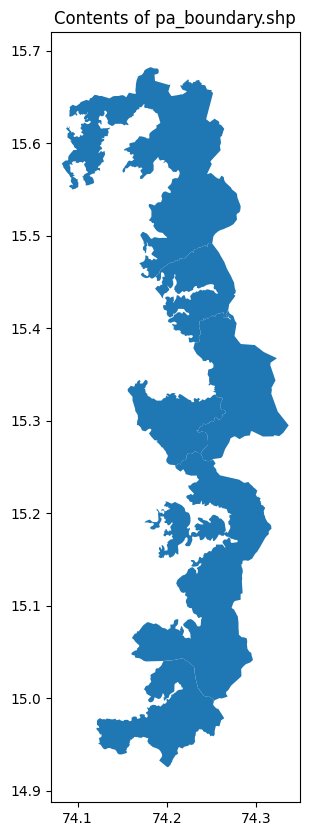

In [19]:
# check shapefile:
import geopandas as gpd
import matplotlib.pyplot as plt
import os

# Path to the shapefile
boundary_path = os.path.join('../data', 'pa_boundary.shp')

# Check if the file exists
if os.path.exists(boundary_path):
    # Load the shapefile
    boundary_gdf = gpd.read_file(boundary_path)
    
    # Print basic information
    print(f"CRS: {boundary_gdf.crs}")
    print(f"Number of features: {len(boundary_gdf)}")
    print(f"Columns: {boundary_gdf.columns.tolist()}")
    
    # Display the first few rows to see attributes
    print("\nAttribute preview:")
    print(boundary_gdf.head())
    
    # Calculate the total area
    area_sqkm = boundary_gdf.geometry.area.sum() / 1e6  # Convert to sq km if in meters
    print(f"\nTotal area: {area_sqkm:.2f} square kilometers")
    
    # Plot the shapefile
    fig, ax = plt.subplots(figsize=(10, 10))
    boundary_gdf.plot(ax=ax)
    ax.set_title('Contents of pa_boundary.shp')
    plt.show()
    
    # Check if it might be a protected area boundary
    if 'name' in boundary_gdf.columns or 'NAME' in boundary_gdf.columns:
        name_col = 'name' if 'name' in boundary_gdf.columns else 'NAME'
        print(f"\nNames of areas in the shapefile:")
        print(boundary_gdf[name_col].unique())
else:
    print(f"Shapefile not found at {boundary_path}")

In [20]:
# Process Landsat 8 data and calculate trends
ls_trends, ls_collection = process_landsat_trends(goa, start_date, end_date)


Processing Landsat 8 data for 2013-03-20 to 2023-02-28...
Calculating trend for ndvi...
Calculating trend for evi...
Calculating trend for msavi...
Calculating trend for mirbi...
Calculating trend for ndmi...
Calculating trend for ndfi...
Calculating trend for nbr...
Calculating trend for nbr2...
Calculating trend for bsi...
Landsat trend calculation complete.


In [21]:
# Process CHIRPS precipitation data and calculate trends
rain_trend, rain_collection = process_chirps_trends(goa, start_date, end_date)
    
# Process SMAP soil moisture data (starts from April 2015)
sm_trend, sm_collection = process_smap_trends(goa, '2015-04-01', end_date)
    
# Process ERA5 data for relative humidity trends
rh_trend, rh_collection = process_era5_trends(goa, start_date, end_date)

Processing CHIRPS precipitation data and calculating trends...
Processing SMAP soil moisture data and calculating trends...
Processing ERA5 data for 2013-03-20 to 2023-02-28...
Available ERA5 bands: ['mean_2m_air_temperature', 'minimum_2m_air_temperature', 'maximum_2m_air_temperature', 'dewpoint_2m_temperature', 'total_precipitation', 'surface_pressure', 'mean_sea_level_pressure', 'u_component_of_wind_10m', 'v_component_of_wind_10m']
ERA5 RH trend calculation complete.


In [22]:
    # Merge all trend layers
all_trends = merge_trend_layers(ls_trends, rain_trend, sm_trend, rh_trend)

In [23]:
# Resample to match JavaScript output
all_trends_resampled = resample_image(all_trends)

In [24]:
#export_to_local(all_trends_resampled, "..data/inputResampled_py.tif", goa)

In [25]:
user_asset_root = 'users/jonasnothnagel/'  # Replace with your actual EE username
export_to_asset(all_trends_resampled, f"{user_asset_root}goa_fire_trends", goa, "goa_fire_trends")

Started export task: goa_fire_trends


<Task MHOURBZQPCJAX6USYD6A5LR3 Type.EXPORT_IMAGE: goa_fire_trends (State.UNSUBMITTED)>